In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
from typing import Tuple, List, Dict

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, cross_validate

# permutation importance
from sklearn.inspection import permutation_importance

import category_encoders as ce


# read data
in_kaggle = False


def get_data_file_path(is_in_kaggle: bool) -> Tuple[str, str, str]:
    train_path = ''
    test_path = ''
    sample_submission_path = ''

    if is_in_kaggle:
        # running in Kaggle, inside the competition
        train_path = '../input/tabular-playground-series-feb-2021/train.csv'
        test_path = '../input/tabular-playground-series-feb-2021/test.csv'
        sample_submission_path = '../input/tabular-playground-series-jan-2021/sample_submission.csv'
    else:
        # running locally
        train_path = 'data/train.csv'
        test_path = 'data/test.csv'
        sample_submission_path = 'data/sample_submission.csv'

    return train_path, test_path, sample_submission_path

def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred) ** 0.5

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)

Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# fix skewness via abs sqrt transform
def sqrt_abs_transform(df: pd.DataFrame) -> pd.DataFrame:

    for c in df.select_dtypes(include = [np.number]).columns:
        df[c] = df[c].abs() ** 0.5
    
    return df

# fix skewness via log transform
def log_transform_numeric_cols(data: pd.DataFrame) -> pd.DataFrame:
    df = data.copy()
    for c in df.select_dtypes(include = [np.number]).columns:
        df[c] = np.log(df[c].values+1)
    return df

# reverse log transform
def exp_transform_numeric_cols(data: pd.DataFrame) -> pd.DataFrame:
    df = data.copy()
    for c in df.select_dtypes(include = [np.number]).columns:
        df[c] = np.exp(df[c].values)-1
    return df

In [3]:
# main flow
start_time = dt.datetime.now()
print("Started at ", start_time)

Started at  2021-02-13 12:45:42.521878


In [4]:
%%time
# get the training set and labels
train_set_path, test_set_path, sample_subm_path = get_data_file_path(in_kaggle)

df_train = pd.read_csv(train_set_path)
df_test = pd.read_csv(test_set_path)

subm = pd.read_csv(sample_subm_path)

Wall time: 1.71 s


In [5]:
df_train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,A,B,A,A,B,D,A,E,C,...,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903,6.994023
1,2,B,A,A,A,B,B,A,E,A,...,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464,8.071256
2,3,A,A,A,C,B,D,A,B,C,...,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352,5.760456
3,4,A,A,A,C,B,D,A,E,G,...,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766,7.806457
4,6,A,B,A,A,B,B,A,E,C,...,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743,6.868974


In [6]:
# list of basic raw numeric features
num_feature_list = [col for col in df_train.columns if col.startswith('cont')]

# list of basic raw numeric features
cat_feature_list = [col for col in df_train.columns if col.startswith('cat')]


# target labels list
target = 'target'

# drop sig_id from train and test sets
df_train = df_train.drop(['id'], axis=1, errors='ignore')
df_test = df_test.drop(['id'], axis=1, errors='ignore')


In [7]:
# do additional feature engineering

encoder = ce.OrdinalEncoder(cols=cat_feature_list, return_df=True)

# Assume our loan data has been imported as df already
# and split into df_train and df_test
df_train_transformed = encoder.fit_transform(df_train)
# df_test = encoder.transform(df_test)

C:\ProgramData\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [8]:
from sklearn.metrics import accuracy_score
import lightgbm as lgb # LightGBM Model


#Additional scklearn functions
from sklearn import metrics   
from sklearn.model_selection import cross_val_score, KFold, cross_validate


# Setting stratified kfold upon the continuous target for future use
kfolds = 5
# Setting kfold for future use
kf = KFold(kfolds, random_state=42, shuffle=True)


# set a hideout fold 

y = df_train_transformed['target']
X_train, X_hideout, y_train, y_hideout = train_test_split(df_train_transformed, y, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train.drop(['target'], axis=1, errors='ignore')
X_hideout = X_hideout.drop(['target'], axis=1, errors='ignore')

def print_lightgbm_feature_importance(X, y, estimator):
    #Print Feature Importance:
    estimator.fit(X, y)
    predictors = X.columns

    feat_imp = pd.Series(estimator.feature_importances_, predictors).sort_values(ascending=False)
    feat_imp.nlargest(30).plot(kind='barh', title='Feature Importances', figsize=(8,10))
    plt.ylabel('Feature Importance Score')
    df = feat_imp.to_frame().reset_index()
    df = df.rename(columns={'index': 'predictor', 0: "fi_score"})
    return df


def model_check(X, y, estimator, model_name, model_description, kfs, is_y_log_transformed=False):
    model_table = pd.DataFrame()
    
    train_rmse = []
    valid_rmse = []
    hideout_rmse = []

    fitting_start_time = dt.datetime.now()
    for i, (train_index, test_index) in enumerate(kfs.split(X)):
        # Create data for this fold
        y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
        X_train, X_valid = X.iloc[train_index, :].copy(), X.iloc[test_index, :].copy()
        
        rmse = 0.0
        
        fit_model = model.fit(X_train, y_train)
        
        pred = model.predict(X_train)
        if is_y_log_transformed:
            # reverse Y to original scale
            y_train = np.exp(y_train) - 1
            pred = np.exp(pred) - 1
        rmse = RMSLE(y_train, pred)
        print('RMSLE Regressor, training set, fold ', i, ': ', rmse)
        train_rmse.append(rmse)
        
        pred = model.predict(X_valid)
        if is_y_log_transformed:
            # reverse Y to original scale
            y_valid = np.exp(y_valid) - 1
            pred = np.exp(pred) - 1
        rmse = RMSLE(y_valid, pred)
        print('RMSLE Regressor, validation set, fold ', i, ': ', rmse)
        valid_rmse.append(rmse)
        
        pred_hideout = model.predict(X_hideout)
        if is_y_log_transformed:
            # reverse Y to original scale
            y_hideout_unscaled = np.exp(y_hideout) - 1
            pred_hideout = np.exp(pred_hideout) - 1
            rmse = RMSLE(y_hideout_unscaled, pred_hideout)
        else:
            rmse = RMSLE(y_hideout, pred_hideout)
        print('RMSLE Regressor, hideout set, fold ', i, ': ', rmse)
        hideout_rmse.append(rmse)
    
    fitting_end_time = dt.datetime.now()
    fit_time = fitting_end_time - fitting_start_time
    
    train_rmse = np.array(train_rmse)
    valid_rmse = np.array(valid_rmse)
    hideout_rmse = np.array(hideout_rmse)
        
    train_rmse = round(np.mean(train_rmse, axis=0), 4)
    val_rmse = round(np.mean(valid_rmse, axis=0), 4)
    test_rmse = round(np.mean(hideout_rmse, axis=0), 4)
    test_std = round(np.std(hideout_rmse, axis=0), 4)

    attributes = {
        'model_name': model_name,
        'train_rmse': train_rmse,
        'valid_rmse': val_rmse,
        'test_rmse': test_rmse,
        'test_rmse_std': test_std,
        'fit_time': fit_time,
        'description': model_description,
    }
    
    model_table = pd.DataFrame(data=[attributes])
    return model_table

In [9]:
# initial not tuned model
model = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    num_leaves=50, 
    max_depth=-1, 
    random_state=314, 
    silent=True,  
    n_jobs=4, 
    n_estimators=100,
    colsample_bytree=0.8,
    subsample=0.8,
    learning_rate=0.1)

In [10]:
# OHE approach + skeweness correcting via log transform

# do additional feature engineering

encoder = ce.OneHotEncoder(cols=cat_feature_list, use_cat_names=True, return_df=True)

# Assume our loan data has been imported as df already
# and split into df_train and df_test
df_train_transformed = encoder.fit_transform(df_train)

# set a hideout fold 

y = df_train_transformed['target']
X_train, X_hideout, y_train, y_hideout = train_test_split(df_train_transformed, y, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train.drop(['target'], axis=1, errors='ignore')
X_hideout = X_hideout.drop(['target'], axis=1, errors='ignore')

X_train = log_transform_numeric_cols(X_train)
X_hideout = log_transform_numeric_cols(X_hideout)

C:\ProgramData\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [11]:
# fit the baseline model with the training data
results_df = model_check(X_train, y_train, model, 
                         "Initial model: OHE+skewness correction", 
                         "Initial baseline - OHE+log transform", kf)
display(results_df.head())

RMSLE Regressor, training set, fold  0 :  0.8251274113765356
RMSLE Regressor, validation set, fold  0 :  0.8472485494826664
RMSLE Regressor, hideout set, fold  0 :  0.8476391112059873
RMSLE Regressor, training set, fold  1 :  0.825252952410935
RMSLE Regressor, validation set, fold  1 :  0.8457247417775715
RMSLE Regressor, hideout set, fold  1 :  0.8476516846486996
RMSLE Regressor, training set, fold  2 :  0.8254631071819676
RMSLE Regressor, validation set, fold  2 :  0.8448369556979022
RMSLE Regressor, hideout set, fold  2 :  0.8471795323784472
RMSLE Regressor, training set, fold  3 :  0.8250541893362834
RMSLE Regressor, validation set, fold  3 :  0.8480480237037447
RMSLE Regressor, hideout set, fold  3 :  0.8476785731745672
RMSLE Regressor, training set, fold  4 :  0.825190157295963
RMSLE Regressor, validation set, fold  4 :  0.8464687834623479
RMSLE Regressor, hideout set, fold  4 :  0.847536048972705


,model_name,train_rmse,valid_rmse,test_rmse,test_rmse_std,fit_time,description
0,Initial model: OHE+skewness correction,0.8252,0.8465,0.8475,0.0002,0 days 00:00:13.285002,Initial baseline - OHE+log transform


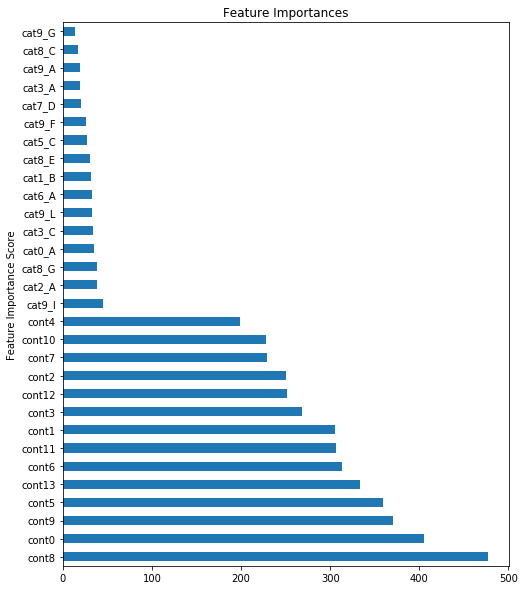

In [12]:
# output the feature importance of the baseline model
feat_imp = print_lightgbm_feature_importance(X_hideout, y_hideout, model)

In [13]:
# tune lightgbm model
colsample_bytree_list = [0.7, 0.75, 0.8, 0.85, 0.9]
subsample_list = [0.7, 0.75, 0.8, 0.85, 0.9]

for colsample in colsample_bytree_list:
    for subsample in subsample_list:
        model = lgb.LGBMRegressor(
            objective='regression',
            metric='rmse',
            num_leaves=50, 
            max_depth=-1, 
            random_state=314, 
            silent=True,  
            n_jobs=4, 
            n_estimators=100,
            colsample_bytree=colsample,
            subsample=subsample,
            learning_rate=0.1)

        description = "".join(['Colsample ', str(colsample), '; Subsample ',  str(subsample)])
        df = model_check(X_train, y_train, model, 
                         "Step 1 - ColSample, Subsample", 
                         description, kf)
        print("Finished checking the model: ", description)
        results_df = pd.concat([results_df, df])

RMSLE Regressor, training set, fold  0 :  0.8254670789209126
RMSLE Regressor, validation set, fold  0 :  0.8472061068676974
RMSLE Regressor, hideout set, fold  0 :  0.8474544464681755
RMSLE Regressor, training set, fold  1 :  0.8258283028147418
RMSLE Regressor, validation set, fold  1 :  0.8452239677905722
RMSLE Regressor, hideout set, fold  1 :  0.8473803017358001
RMSLE Regressor, training set, fold  2 :  0.8259056293487582
RMSLE Regressor, validation set, fold  2 :  0.844209834544798
RMSLE Regressor, hideout set, fold  2 :  0.8470580465245793
RMSLE Regressor, training set, fold  3 :  0.8253483342577408
RMSLE Regressor, validation set, fold  3 :  0.8476065492004469
RMSLE Regressor, hideout set, fold  3 :  0.8471586122491762
RMSLE Regressor, training set, fold  4 :  0.8253539192142756
RMSLE Regressor, validation set, fold  4 :  0.8462919702240604
RMSLE Regressor, hideout set, fold  4 :  0.847191393544236
Finished checking the model:  Colsample 0.7; Subsample 0.7
RMSLE Regressor, traini

RMSLE Regressor, training set, fold  2 :  0.8257232142534435
RMSLE Regressor, validation set, fold  2 :  0.8442671226901258
RMSLE Regressor, hideout set, fold  2 :  0.8472531946892939
RMSLE Regressor, training set, fold  3 :  0.8250461273832298
RMSLE Regressor, validation set, fold  3 :  0.8478122396916142
RMSLE Regressor, hideout set, fold  3 :  0.8475937554597267
RMSLE Regressor, training set, fold  4 :  0.8252697952222915
RMSLE Regressor, validation set, fold  4 :  0.846367818483857
RMSLE Regressor, hideout set, fold  4 :  0.8472691954594824
Finished checking the model:  Colsample 0.75; Subsample 0.85
RMSLE Regressor, training set, fold  0 :  0.8253029869363355
RMSLE Regressor, validation set, fold  0 :  0.8473504620010057
RMSLE Regressor, hideout set, fold  0 :  0.8475040903367013
RMSLE Regressor, training set, fold  1 :  0.8255356589491141
RMSLE Regressor, validation set, fold  1 :  0.8454435896095507
RMSLE Regressor, hideout set, fold  1 :  0.8476313844069443
RMSLE Regressor, tra

RMSLE Regressor, hideout set, fold  4 :  0.8472928013249602
Finished checking the model:  Colsample 0.85; Subsample 0.75
RMSLE Regressor, training set, fold  0 :  0.8247735441636508
RMSLE Regressor, validation set, fold  0 :  0.8471326750370942
RMSLE Regressor, hideout set, fold  0 :  0.8476415297309773
RMSLE Regressor, training set, fold  1 :  0.8249771399985645
RMSLE Regressor, validation set, fold  1 :  0.8453303242353994
RMSLE Regressor, hideout set, fold  1 :  0.8477914482919136
RMSLE Regressor, training set, fold  2 :  0.8254778884632387
RMSLE Regressor, validation set, fold  2 :  0.844908843604778
RMSLE Regressor, hideout set, fold  2 :  0.8471137049357195
RMSLE Regressor, training set, fold  3 :  0.8243571052959129
RMSLE Regressor, validation set, fold  3 :  0.8477301478700247
RMSLE Regressor, hideout set, fold  3 :  0.8476309436288492
RMSLE Regressor, training set, fold  4 :  0.8248489200759035
RMSLE Regressor, validation set, fold  4 :  0.8462871148857911
RMSLE Regressor, hid

In [14]:
# interim results 
results_df.reset_index().sort_values('test_rmse', 
                   ascending=True)[
                        [ 
                            'train_rmse', 'valid_rmse', 'test_rmse',
                            'test_rmse_std', 'fit_time', 'description'
                        ]
                              ][:40].style.background_gradient(cmap='Oranges')

,train_rmse,valid_rmse,test_rmse,test_rmse_std,fit_time,description
1,0.825600,0.846100,0.847200,0.000100,0 days 00:00:13.073045,Colsample 0.7; Subsample 0.7
2,0.825600,0.846100,0.847200,0.000100,0 days 00:00:12.594001,Colsample 0.7; Subsample 0.75
3,0.825600,0.846100,0.847200,0.000100,0 days 00:00:12.482998,Colsample 0.7; Subsample 0.8
4,0.825600,0.846100,0.847200,0.000100,0 days 00:00:12.470002,Colsample 0.7; Subsample 0.85
5,0.825600,0.846100,0.847200,0.000100,0 days 00:00:12.687003,Colsample 0.7; Subsample 0.9
0,0.825200,0.846500,0.847500,0.000200,0 days 00:00:13.285002,Initial baseline - OHE+log transform
20,0.824900,0.846300,0.847500,0.000300,0 days 00:00:14.451997,Colsample 0.85; Subsample 0.9
19,0.824900,0.846300,0.847500,0.000300,0 days 00:00:14.427005,Colsample 0.85; Subsample 0.85
18,0.824900,0.846300,0.847500,0.000300,0 days 00:00:13.716000,Colsample 0.85; Subsample 0.8
17,0.824900,0.846300,0.847500,0.000300,0 days 00:00:13.114001,Colsample 0.85; Subsample 0.75


In [15]:
num_leaves_list = [1500, 1600, 1700, 1800, 1900, 2000]
for num in num_leaves_list:
    model = lgb.LGBMRegressor(
            objective='regression',
            metric='rmse',
            num_leaves=50, 
            max_depth=-1, 
            random_state=314, 
            silent=True, 
            n_jobs=4, 
            n_estimators=100,
            colsample_bytree=0.7,
            subsample=0.7,
            learning_rate=0.1)

    description = "".join(['NumLeaves ', str(num)])
    df = model_check(X_train, y_train, model, 
                         "Step 2 - NumLeaves", 
                         description, kf)

    print("Finished checking the model: ", description)
    results_df = pd.concat([results_df, df])

RMSLE Regressor, training set, fold  0 :  0.8254670789209126
RMSLE Regressor, validation set, fold  0 :  0.8472061068676974
RMSLE Regressor, hideout set, fold  0 :  0.8474544464681755
RMSLE Regressor, training set, fold  1 :  0.8258283028147418
RMSLE Regressor, validation set, fold  1 :  0.8452239677905722
RMSLE Regressor, hideout set, fold  1 :  0.8473803017358001
RMSLE Regressor, training set, fold  2 :  0.8259056293487582
RMSLE Regressor, validation set, fold  2 :  0.844209834544798
RMSLE Regressor, hideout set, fold  2 :  0.8470580465245793
RMSLE Regressor, training set, fold  3 :  0.8253483342577408
RMSLE Regressor, validation set, fold  3 :  0.8476065492004469
RMSLE Regressor, hideout set, fold  3 :  0.8471586122491762
RMSLE Regressor, training set, fold  4 :  0.8253539192142756
RMSLE Regressor, validation set, fold  4 :  0.8462919702240604
RMSLE Regressor, hideout set, fold  4 :  0.847191393544236
Finished checking the model:  NumLeaves 1500
RMSLE Regressor, training set, fold  

In [16]:
# interim results 
results_df.reset_index().sort_values('test_rmse', 
                   ascending=True)[
                        [ 
                            'train_rmse', 'valid_rmse', 'test_rmse',
                            'test_rmse_std', 'fit_time', 'description'
                        ]
                              ][:40].style.background_gradient(cmap='Oranges')

,train_rmse,valid_rmse,test_rmse,test_rmse_std,fit_time,description
31,0.825600,0.846100,0.847200,0.000100,0 days 00:00:13.048000,NumLeaves 2000
1,0.825600,0.846100,0.847200,0.000100,0 days 00:00:13.073045,Colsample 0.7; Subsample 0.7
2,0.825600,0.846100,0.847200,0.000100,0 days 00:00:12.594001,Colsample 0.7; Subsample 0.75
3,0.825600,0.846100,0.847200,0.000100,0 days 00:00:12.482998,Colsample 0.7; Subsample 0.8
4,0.825600,0.846100,0.847200,0.000100,0 days 00:00:12.470002,Colsample 0.7; Subsample 0.85
5,0.825600,0.846100,0.847200,0.000100,0 days 00:00:12.687003,Colsample 0.7; Subsample 0.9
29,0.825600,0.846100,0.847200,0.000100,0 days 00:00:12.501002,NumLeaves 1800
28,0.825600,0.846100,0.847200,0.000100,0 days 00:00:12.479997,NumLeaves 1700
27,0.825600,0.846100,0.847200,0.000100,0 days 00:00:12.905001,NumLeaves 1600
26,0.825600,0.846100,0.847200,0.000100,0 days 00:00:13.229000,NumLeaves 1500


In [17]:
min_child_samples = [1200, 1300, 1400,1500, 1600]
for num in min_child_samples:
    model = lgb.LGBMRegressor(
            objective='regression',
            metric='rmse',
            num_leaves=2000, 
            min_child_samples=num, 
            max_depth=-1, 
            random_state=314, 
            silent=True, 
            n_jobs=4, 
            n_estimators=100,
            colsample_bytree=0.7,
            subsample=0.7,
            learning_rate=0.1)

    description = "".join(['MinChildSamples ', str(num)])
    df = model_check(X_train, y_train, model, 
                         "Step 3 - MinChildSamples", 
                         description, kf)
    print("Finished checking the model: ", description)
    results_df = pd.concat([results_df, df])

RMSLE Regressor, training set, fold  0 :  0.817583943511174
RMSLE Regressor, validation set, fold  0 :  0.8462605932551661
RMSLE Regressor, hideout set, fold  0 :  0.8462094750750729
RMSLE Regressor, training set, fold  1 :  0.8178274737444086
RMSLE Regressor, validation set, fold  1 :  0.8445316220263186
RMSLE Regressor, hideout set, fold  1 :  0.8461547332344234
RMSLE Regressor, training set, fold  2 :  0.817933228832631
RMSLE Regressor, validation set, fold  2 :  0.8438572258376791
RMSLE Regressor, hideout set, fold  2 :  0.846187788674669
RMSLE Regressor, training set, fold  3 :  0.8172140480976264
RMSLE Regressor, validation set, fold  3 :  0.8466721829942859
RMSLE Regressor, hideout set, fold  3 :  0.8465385492230109
RMSLE Regressor, training set, fold  4 :  0.817601936729445
RMSLE Regressor, validation set, fold  4 :  0.8457642895693872
RMSLE Regressor, hideout set, fold  4 :  0.8464675472732914
Finished checking the model:  MinChildSamples 1200
RMSLE Regressor, training set, fo

In [18]:
# interim results 
results_df.reset_index().sort_values('test_rmse', 
                   ascending=True)[
                        [ 
                            'train_rmse', 'valid_rmse', 'test_rmse',
                            'test_rmse_std', 'fit_time', 'description'
                        ]
                              ][:40].style.background_gradient(cmap='Oranges')

,train_rmse,valid_rmse,test_rmse,test_rmse_std,fit_time,description
36,0.824600,0.845200,0.846300,0.000100,0 days 00:00:15.170999,MinChildSamples 1600
33,0.819700,0.845400,0.846300,0.000100,0 days 00:00:15.948999,MinChildSamples 1300
32,0.817600,0.845400,0.846300,0.000200,0 days 00:00:16.270994,MinChildSamples 1200
34,0.821600,0.845500,0.846400,0.000100,0 days 00:00:15.454999,MinChildSamples 1400
35,0.823200,0.845500,0.846400,0.000100,0 days 00:00:15.686041,MinChildSamples 1500
3,0.825600,0.846100,0.847200,0.000100,0 days 00:00:12.482998,Colsample 0.7; Subsample 0.8
4,0.825600,0.846100,0.847200,0.000100,0 days 00:00:12.470002,Colsample 0.7; Subsample 0.85
5,0.825600,0.846100,0.847200,0.000100,0 days 00:00:12.687003,Colsample 0.7; Subsample 0.9
1,0.825600,0.846100,0.847200,0.000100,0 days 00:00:13.073045,Colsample 0.7; Subsample 0.7
31,0.825600,0.846100,0.847200,0.000100,0 days 00:00:13.048000,NumLeaves 2000


In [19]:
min_child_weights = [0.0001, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
for num in min_child_weights:
    model = lgb.LGBMRegressor(
            objective='regression',
            metric='rmse',
            num_leaves=2000, 
            min_child_samples=1600, 
            min_child_weights = num,
            max_depth=-1, 
            random_state=314, 
            silent=True, 
            n_jobs=4, 
            n_estimators=100,
            colsample_bytree=0.7,
            subsample=0.7,
            learning_rate=0.1)

    description = "".join(['MinChildWeight ', str(num)])
    df = model_check(X_train, y_train, model, 
                         "Step 4 - MinChildWeight", 
                         description, kf)
    print("Finished checking the model: ", description)
    results_df = pd.concat([results_df, df])

RMSLE Regressor, training set, fold  0 :  0.824394959149899
RMSLE Regressor, validation set, fold  0 :  0.8460659786127595
RMSLE Regressor, hideout set, fold  0 :  0.8461367217572613
RMSLE Regressor, training set, fold  1 :  0.8248353249178164
RMSLE Regressor, validation set, fold  1 :  0.8445231737284327
RMSLE Regressor, hideout set, fold  1 :  0.8463123729658744
RMSLE Regressor, training set, fold  2 :  0.8249468199947508
RMSLE Regressor, validation set, fold  2 :  0.8431619531175462
RMSLE Regressor, hideout set, fold  2 :  0.8463331054780726
RMSLE Regressor, training set, fold  3 :  0.8244955602801721
RMSLE Regressor, validation set, fold  3 :  0.8466946275466103
RMSLE Regressor, hideout set, fold  3 :  0.8462914188640123
RMSLE Regressor, training set, fold  4 :  0.8243821610092075
RMSLE Regressor, validation set, fold  4 :  0.8455368243053003
RMSLE Regressor, hideout set, fold  4 :  0.8463462000858227
Finished checking the model:  MinChildWeight 0.0001
RMSLE Regressor, training set

RMSLE Regressor, hideout set, fold  2 :  0.8463331054780726
RMSLE Regressor, training set, fold  3 :  0.8244955602801721
RMSLE Regressor, validation set, fold  3 :  0.8466946275466103
RMSLE Regressor, hideout set, fold  3 :  0.8462914188640123
RMSLE Regressor, training set, fold  4 :  0.8243821610092075
RMSLE Regressor, validation set, fold  4 :  0.8455368243053003
RMSLE Regressor, hideout set, fold  4 :  0.8463462000858227
Finished checking the model:  MinChildWeight 0.1
RMSLE Regressor, training set, fold  0 :  0.824394959149899
RMSLE Regressor, validation set, fold  0 :  0.8460659786127595
RMSLE Regressor, hideout set, fold  0 :  0.8461367217572613
RMSLE Regressor, training set, fold  1 :  0.8248353249178164
RMSLE Regressor, validation set, fold  1 :  0.8445231737284327
RMSLE Regressor, hideout set, fold  1 :  0.8463123729658744
RMSLE Regressor, training set, fold  2 :  0.8249468199947508
RMSLE Regressor, validation set, fold  2 :  0.8431619531175462
RMSLE Regressor, hideout set, fo

In [20]:
# interim results 
results_df.reset_index().sort_values('test_rmse', 
                   ascending=True)[
                        [ 
                            'train_rmse', 'valid_rmse', 'test_rmse',
                            'test_rmse_std', 'fit_time', 'description'
                        ]
                              ][:40].style.background_gradient(cmap='Oranges')

,train_rmse,valid_rmse,test_rmse,test_rmse_std,fit_time,description
47,0.824600,0.845200,0.846300,0.000100,0 days 00:00:15.065001,MinChildWeight 0.5
46,0.824600,0.845200,0.846300,0.000100,0 days 00:00:15.103002,MinChildWeight 0.2
32,0.817600,0.845400,0.846300,0.000200,0 days 00:00:16.270994,MinChildSamples 1200
33,0.819700,0.845400,0.846300,0.000100,0 days 00:00:15.948999,MinChildSamples 1300
36,0.824600,0.845200,0.846300,0.000100,0 days 00:00:15.170999,MinChildSamples 1600
37,0.824600,0.845200,0.846300,0.000100,0 days 00:00:15.105000,MinChildWeight 0.0001
39,0.824600,0.845200,0.846300,0.000100,0 days 00:00:15.325999,MinChildWeight 0.001
40,0.824600,0.845200,0.846300,0.000100,0 days 00:00:15.095044,MinChildWeight 0.002
41,0.824600,0.845200,0.846300,0.000100,0 days 00:00:15.113041,MinChildWeight 0.005
38,0.824600,0.845200,0.846300,0.000100,0 days 00:00:15.056000,MinChildWeight 0.0005


In [21]:
reg_alphas = [0.0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1,2,3]
for num in reg_alphas:    
    model = lgb.LGBMRegressor(
            objective='regression',
            metric='rmse',
            num_leaves=2000, 
            min_child_samples=1600, 
            min_child_weights=0.5,
            reg_alpha=num,
            max_depth=-1, 
            random_state=314, 
            silent=True, 
            n_jobs=4, 
            n_estimators=100,
            colsample_bytree=0.7,
            subsample=0.7,
            learning_rate=0.1)

    description = "".join(['RegAlpha ', str(num)])
    df = model_check(X_train, y_train, model, 
                         "Step 5 - RegAlpha", 
                         description, kf)

    print("Finished checking the model: ", description)
    results_df = pd.concat([results_df, df])

RMSLE Regressor, training set, fold  0 :  0.824394959149899
RMSLE Regressor, validation set, fold  0 :  0.8460659786127595
RMSLE Regressor, hideout set, fold  0 :  0.8461367217572613
RMSLE Regressor, training set, fold  1 :  0.8248353249178164
RMSLE Regressor, validation set, fold  1 :  0.8445231737284327
RMSLE Regressor, hideout set, fold  1 :  0.8463123729658744
RMSLE Regressor, training set, fold  2 :  0.8249468199947508
RMSLE Regressor, validation set, fold  2 :  0.8431619531175462
RMSLE Regressor, hideout set, fold  2 :  0.8463331054780726
RMSLE Regressor, training set, fold  3 :  0.8244955602801721
RMSLE Regressor, validation set, fold  3 :  0.8466946275466103
RMSLE Regressor, hideout set, fold  3 :  0.8462914188640123
RMSLE Regressor, training set, fold  4 :  0.8243821610092075
RMSLE Regressor, validation set, fold  4 :  0.8455368243053003
RMSLE Regressor, hideout set, fold  4 :  0.8463462000858227
Finished checking the model:  RegAlpha 0.0
RMSLE Regressor, training set, fold  0

RMSLE Regressor, training set, fold  3 :  0.8245111265552906
RMSLE Regressor, validation set, fold  3 :  0.8469287153742765
RMSLE Regressor, hideout set, fold  3 :  0.8464891974834408
RMSLE Regressor, training set, fold  4 :  0.8245884029411319
RMSLE Regressor, validation set, fold  4 :  0.8459212072390733
RMSLE Regressor, hideout set, fold  4 :  0.8461497500354382
Finished checking the model:  RegAlpha 0.2
RMSLE Regressor, training set, fold  0 :  0.8245484511708928
RMSLE Regressor, validation set, fold  0 :  0.8460412896224374
RMSLE Regressor, hideout set, fold  0 :  0.8464437434336289
RMSLE Regressor, training set, fold  1 :  0.8249959447238195
RMSLE Regressor, validation set, fold  1 :  0.8440090662486123
RMSLE Regressor, hideout set, fold  1 :  0.8466544693842235
RMSLE Regressor, training set, fold  2 :  0.8249524519378095
RMSLE Regressor, validation set, fold  2 :  0.8437107506055195
RMSLE Regressor, hideout set, fold  2 :  0.8463866144159848
RMSLE Regressor, training set, fold  

In [22]:
# interim results 
results_df.reset_index().sort_values('test_rmse', 
                   ascending=True)[
                        [ 
                            'train_rmse', 'valid_rmse', 'test_rmse',
                            'test_rmse_std', 'fit_time', 'description'
                        ]
                              ][:40].style.background_gradient(cmap='Oranges')

,train_rmse,valid_rmse,test_rmse,test_rmse_std,fit_time,description
45,0.824600,0.845200,0.846300,0.000100,0 days 00:00:15.052000,MinChildWeight 0.1
43,0.824600,0.845200,0.846300,0.000100,0 days 00:00:14.932996,MinChildWeight 0.02
44,0.824600,0.845200,0.846300,0.000100,0 days 00:00:15.448001,MinChildWeight 0.05
40,0.824600,0.845200,0.846300,0.000100,0 days 00:00:15.095044,MinChildWeight 0.002
46,0.824600,0.845200,0.846300,0.000100,0 days 00:00:15.103002,MinChildWeight 0.2
47,0.824600,0.845200,0.846300,0.000100,0 days 00:00:15.065001,MinChildWeight 0.5
48,0.824600,0.845200,0.846300,0.000100,0 days 00:00:15.459001,RegAlpha 0.0
49,0.824600,0.845100,0.846300,0.000100,0 days 00:00:14.886999,RegAlpha 0.001
42,0.824600,0.845200,0.846300,0.000100,0 days 00:00:15.149002,MinChildWeight 0.01
39,0.824600,0.845200,0.846300,0.000100,0 days 00:00:15.325999,MinChildWeight 0.001


In [23]:
reg_lambdas = [0.0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1,2,3]
for num in reg_lambdas:    
    model = lgb.LGBMRegressor(
            objective='regression',
            metric='rmse',
            num_leaves=2000, 
            min_child_samples=1600, 
            min_child_weights=0.5,
            reg_alpha=0.01,
            reg_lambda=num,
            max_depth=-1, 
            random_state=314, 
            silent=True, 
            n_jobs=4, 
            n_estimators=100,
            colsample_bytree=0.7,
            subsample=0.7,
            learning_rate=0.1)

    description = "".join(['RegLambda ', str(num)])
    df = model_check(X_train, y_train, model, 
                         "Step 6 - RegLambda", 
                         description, kf)


    print("Finished checking the model: ", description)
    results_df = pd.concat([results_df, df])

RMSLE Regressor, training set, fold  0 :  0.82444448029339
RMSLE Regressor, validation set, fold  0 :  0.8462251505624737
RMSLE Regressor, hideout set, fold  0 :  0.8464045373807657
RMSLE Regressor, training set, fold  1 :  0.824755233043882
RMSLE Regressor, validation set, fold  1 :  0.8442777041019677
RMSLE Regressor, hideout set, fold  1 :  0.8466151698390925
RMSLE Regressor, training set, fold  2 :  0.8250729687637837
RMSLE Regressor, validation set, fold  2 :  0.8431736512390564
RMSLE Regressor, hideout set, fold  2 :  0.8462380736323917
RMSLE Regressor, training set, fold  3 :  0.8245222785624167
RMSLE Regressor, validation set, fold  3 :  0.8466420853026645
RMSLE Regressor, hideout set, fold  3 :  0.8463717773577889
RMSLE Regressor, training set, fold  4 :  0.8243762943982489
RMSLE Regressor, validation set, fold  4 :  0.8455809349116634
RMSLE Regressor, hideout set, fold  4 :  0.8463478210381864
Finished checking the model:  RegLambda 0.0
RMSLE Regressor, training set, fold  0 

RMSLE Regressor, hideout set, fold  2 :  0.8462429768208253
RMSLE Regressor, training set, fold  3 :  0.8245236836548399
RMSLE Regressor, validation set, fold  3 :  0.8466420571890534
RMSLE Regressor, hideout set, fold  3 :  0.8463717746051205
RMSLE Regressor, training set, fold  4 :  0.8245479241231131
RMSLE Regressor, validation set, fold  4 :  0.8458033007604012
RMSLE Regressor, hideout set, fold  4 :  0.8462677275722175
Finished checking the model:  RegLambda 0.2
RMSLE Regressor, training set, fold  0 :  0.8246422145264583
RMSLE Regressor, validation set, fold  0 :  0.8463265346979577
RMSLE Regressor, hideout set, fold  0 :  0.8466048753667405
RMSLE Regressor, training set, fold  1 :  0.8247074095146675
RMSLE Regressor, validation set, fold  1 :  0.8445214994216118
RMSLE Regressor, hideout set, fold  1 :  0.8462043714825878
RMSLE Regressor, training set, fold  2 :  0.8251381087312338
RMSLE Regressor, validation set, fold  2 :  0.8431582882977011
RMSLE Regressor, hideout set, fold  

In [24]:
# interim results 
results_df.reset_index().sort_values('test_rmse', 
                   ascending=True)[
                        [ 
                            'train_rmse', 'valid_rmse', 'test_rmse',
                            'test_rmse_std', 'fit_time', 'description'
                        ]
                              ][:40].style.background_gradient(cmap='Oranges')

,train_rmse,valid_rmse,test_rmse,test_rmse_std,fit_time,description
36,0.824600,0.845200,0.846300,0.000100,0 days 00:00:15.170999,MinChildSamples 1600
32,0.817600,0.845400,0.846300,0.000200,0 days 00:00:16.270994,MinChildSamples 1200
37,0.824600,0.845200,0.846300,0.000100,0 days 00:00:15.105000,MinChildWeight 0.0001
38,0.824600,0.845200,0.846300,0.000100,0 days 00:00:15.056000,MinChildWeight 0.0005
39,0.824600,0.845200,0.846300,0.000100,0 days 00:00:15.325999,MinChildWeight 0.001
40,0.824600,0.845200,0.846300,0.000100,0 days 00:00:15.095044,MinChildWeight 0.002
41,0.824600,0.845200,0.846300,0.000100,0 days 00:00:15.113041,MinChildWeight 0.005
42,0.824600,0.845200,0.846300,0.000100,0 days 00:00:15.149002,MinChildWeight 0.01
43,0.824600,0.845200,0.846300,0.000100,0 days 00:00:14.932996,MinChildWeight 0.02
44,0.824600,0.845200,0.846300,0.000100,0 days 00:00:15.448001,MinChildWeight 0.05


In [26]:
# choosing the optimal learning rate - pass 1

rates = [
       {'rate': 0.1, 'n': 100},
       {'rate': 0.07, 'n': 180},
       {'rate': 0.05, 'n': 200},
       {'rate': 0.02, 'n': 500}, 
       {'rate': 0.01, 'n': 1000},
       {'rate': 0.009, 'n': 1200},
       {'rate': 0.005, 'n': 2000},
       {'rate': 0.004, 'n': 3500},
       {'rate': 0.002, 'n': 5000},
       {'rate': 0.001, 'n': 10000},           
]

for rate in rates:
    
    model = lgb.LGBMRegressor(
            objective='regression',
            metric='rmse',
            num_leaves=2000, 
            min_child_samples=1600, 
            min_child_weights=0.5,
            reg_alpha=0.01,
            reg_lambda=num,
            max_depth=-1, 
            random_state=314, 
            silent=True, 
            n_jobs=4, 
            colsample_bytree=0.7,
            subsample=0.7,
             n_estimators=rate['n'],
            learning_rate=rate['rate'])

    description = "".join(['LR ', str(rate['rate']), '; nrounds=', str(rate['n'])])
    df = model_check(X_train, y_train, model, 
                         "Step 7 - LR", 
                         description, kf)
    
    print("Finished checking the model: ", description)
    results_df = pd.concat([results_df, df])

RMSLE Regressor, training set, fold  0 :  0.8244559977943909
RMSLE Regressor, validation set, fold  0 :  0.8460651434420192
RMSLE Regressor, hideout set, fold  0 :  0.8464119938080141
RMSLE Regressor, training set, fold  1 :  0.8248800763740252
RMSLE Regressor, validation set, fold  1 :  0.8441238556150097
RMSLE Regressor, hideout set, fold  1 :  0.8465118162000315
RMSLE Regressor, training set, fold  2 :  0.8249489263475951
RMSLE Regressor, validation set, fold  2 :  0.8438578978664943
RMSLE Regressor, hideout set, fold  2 :  0.8461329516212732
RMSLE Regressor, training set, fold  3 :  0.8245510930818258
RMSLE Regressor, validation set, fold  3 :  0.8468357482920598
RMSLE Regressor, hideout set, fold  3 :  0.8465078529600205
RMSLE Regressor, training set, fold  4 :  0.8246024232211779
RMSLE Regressor, validation set, fold  4 :  0.845803957880622
RMSLE Regressor, hideout set, fold  4 :  0.8464261570427469
Finished checking the model:  LR 0.1; nrounds=100
RMSLE Regressor, training set, 

RMSLE Regressor, hideout set, fold  2 :  0.8453695527942391
RMSLE Regressor, training set, fold  3 :  0.8236497355366801
RMSLE Regressor, validation set, fold  3 :  0.8459992867038395
RMSLE Regressor, hideout set, fold  3 :  0.8455479406479867
RMSLE Regressor, training set, fold  4 :  0.823861084034502
RMSLE Regressor, validation set, fold  4 :  0.844963826875891
RMSLE Regressor, hideout set, fold  4 :  0.8455291855795243
Finished checking the model:  LR 0.002; nrounds=5000
RMSLE Regressor, training set, fold  0 :  0.8238411467155516
RMSLE Regressor, validation set, fold  0 :  0.8453857415144204
RMSLE Regressor, hideout set, fold  0 :  0.8455636832410344
RMSLE Regressor, training set, fold  1 :  0.8242504617445171
RMSLE Regressor, validation set, fold  1 :  0.843521513860179
RMSLE Regressor, hideout set, fold  1 :  0.8456676874251702
RMSLE Regressor, training set, fold  2 :  0.8243460339618097
RMSLE Regressor, validation set, fold  2 :  0.8426947214330952
RMSLE Regressor, hideout set, 

In [27]:
# interim results 
results_df.reset_index().sort_values('test_rmse', 
                   ascending=True)[
                        [ 
                            'train_rmse', 'valid_rmse', 'test_rmse',
                            'test_rmse_std', 'fit_time', 'description'
                        ]
                              ][:40].style.background_gradient(cmap='Oranges')

,train_rmse,valid_rmse,test_rmse,test_rmse_std,fit_time,description
81,0.816400,0.843900,0.845000,0.000100,0 days 00:08:46.908059,LR 0.004; nrounds=3500
79,0.822400,0.844400,0.845400,0.000100,0 days 00:02:17.488014,LR 0.009; nrounds=1200
83,0.824000,0.844500,0.845500,0.000100,0 days 00:25:50.468285,LR 0.001; nrounds=10000
82,0.824000,0.844500,0.845500,0.000100,0 days 00:13:28.655031,LR 0.002; nrounds=5000
80,0.824000,0.844500,0.845600,0.000100,0 days 00:04:13.478518,LR 0.005; nrounds=2000
78,0.824000,0.844600,0.845600,0.000100,0 days 00:01:52.120997,LR 0.01; nrounds=1000
77,0.824100,0.844500,0.845700,0.000100,0 days 00:00:55.751002,LR 0.02; nrounds=500
76,0.824300,0.844900,0.845900,0.000100,0 days 00:00:24.752003,LR 0.05; nrounds=200
75,0.819500,0.844700,0.845900,0.000100,0 days 00:00:22.524995,LR 0.07; nrounds=180
36,0.824600,0.845200,0.846300,0.000100,0 days 00:00:15.170999,MinChildSamples 1600


In [28]:
# choosing the optimal learning rate - pass 2

rates = [
    {'rate': 0.004, 'n': 3300},
    {'rate': 0.004, 'n': 3400},
    {'rate': 0.004, 'n': 3550},
    {'rate': 0.004, 'n': 3600},
    {'rate': 0.004, 'n': 3700},
    {'rate': 0.004, 'n': 3800},
    {'rate': 0.0039, 'n': 3500},
    {'rate': 0.0039, 'n': 3600},  
    {'rate': 0.0041, 'n': 3500},
    {'rate': 0.0041, 'n': 3600},  
    {'rate': 0.0042, 'n': 3500},
    {'rate': 0.0042, 'n': 3600},           
]

for rate in rates:
    
    model = lgb.LGBMRegressor(
            objective='regression',
            metric='rmse',
            num_leaves=2000, 
            min_child_samples=1600, 
            min_child_weights=0.5,
            reg_alpha=0.01,
            max_depth=-1, 
            random_state=314, 
            silent=True, 
            n_jobs=4, 
            colsample_bytree=0.7,
            subsample=0.7,
             n_estimators=rate['n'],
            learning_rate=rate['rate'])

    description = "".join(['LR ', str(rate['rate']), '; nrounds=', str(rate['n'])])
    df = model_check(X_train, y_train, model, 
                         "Step 8 - LR, pass 2", 
                         description, kf)
    
    print("Finished checking the model: ", description)
    results_df = pd.concat([results_df, df])

RMSLE Regressor, training set, fold  0 :  0.8176634590283942
RMSLE Regressor, validation set, fold  0 :  0.8446735541729847
RMSLE Regressor, hideout set, fold  0 :  0.845088279864976
RMSLE Regressor, training set, fold  1 :  0.818022975255682
RMSLE Regressor, validation set, fold  1 :  0.8430184619061372
RMSLE Regressor, hideout set, fold  1 :  0.8451369686083052
RMSLE Regressor, training set, fold  2 :  0.8181183212400146
RMSLE Regressor, validation set, fold  2 :  0.8421821485342993
RMSLE Regressor, hideout set, fold  2 :  0.8449613206050504
RMSLE Regressor, training set, fold  3 :  0.817534705392307
RMSLE Regressor, validation set, fold  3 :  0.8454470119888581
RMSLE Regressor, hideout set, fold  3 :  0.8449374403929281
RMSLE Regressor, training set, fold  4 :  0.8177051817111969
RMSLE Regressor, validation set, fold  4 :  0.8444951853738393
RMSLE Regressor, hideout set, fold  4 :  0.8450134308892681
Finished checking the model:  LR 0.004; nrounds=3300
RMSLE Regressor, training set,

RMSLE Regressor, validation set, fold  2 :  0.842195377577724
RMSLE Regressor, hideout set, fold  2 :  0.8449744392931876
RMSLE Regressor, training set, fold  3 :  0.81546499127176
RMSLE Regressor, validation set, fold  3 :  0.8453335628070799
RMSLE Regressor, hideout set, fold  3 :  0.8449624939474231
RMSLE Regressor, training set, fold  4 :  0.8156563555235552
RMSLE Regressor, validation set, fold  4 :  0.8444919449501904
RMSLE Regressor, hideout set, fold  4 :  0.8450271350126153
Finished checking the model:  LR 0.0041; nrounds=3500
RMSLE Regressor, training set, fold  0 :  0.814968047050734
RMSLE Regressor, validation set, fold  0 :  0.8445883051389178
RMSLE Regressor, hideout set, fold  0 :  0.8449548614662443
RMSLE Regressor, training set, fold  1 :  0.8153264518016001
RMSLE Regressor, validation set, fold  1 :  0.8429839185766833
RMSLE Regressor, hideout set, fold  1 :  0.8450593221317061
RMSLE Regressor, training set, fold  2 :  0.8154557674541669
RMSLE Regressor, validation se

In [29]:
# interim results 
results_df.reset_index().sort_values('test_rmse', 
                   ascending=True)[
                        [ 
                            'train_rmse', 'valid_rmse', 'test_rmse',
                            'test_rmse_std', 'fit_time', 'description'
                        ]
                              ][:40].style.background_gradient(cmap='Oranges')

,train_rmse,valid_rmse,test_rmse,test_rmse_std,fit_time,description
95,0.814500,0.843900,0.845000,0.000100,0 days 00:09:06.735196,LR 0.0042; nrounds=3600
81,0.816400,0.843900,0.845000,0.000100,0 days 00:08:46.908059,LR 0.004; nrounds=3500
84,0.817800,0.844000,0.845000,0.000100,0 days 00:07:17.599670,LR 0.004; nrounds=3300
85,0.817100,0.843900,0.845000,0.000100,0 days 00:08:36.290942,LR 0.004; nrounds=3400
87,0.815700,0.843900,0.845000,0.000100,0 days 00:08:34.693025,LR 0.004; nrounds=3600
88,0.815000,0.843900,0.845000,0.000100,0 days 00:08:24.905532,LR 0.004; nrounds=3700
86,0.816000,0.843900,0.845000,0.000100,0 days 00:09:12.825011,LR 0.004; nrounds=3550
90,0.817000,0.844000,0.845000,0.000100,0 days 00:07:54.089760,LR 0.0039; nrounds=3500
91,0.816300,0.843900,0.845000,0.000100,0 days 00:09:56.064027,LR 0.0039; nrounds=3600
92,0.815800,0.843900,0.845000,0.000000,0 days 00:08:59.376315,LR 0.0041; nrounds=3500


In [32]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 71 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0_A  200000 non-null  float64
 1   cat0_B  200000 non-null  float64
 2   cat1_B  200000 non-null  float64
 3   cat1_A  200000 non-null  float64
 4   cat2_A  200000 non-null  float64
 5   cat2_B  200000 non-null  float64
 6   cat3_A  200000 non-null  float64
 7   cat3_C  200000 non-null  float64
 8   cat3_D  200000 non-null  float64
 9   cat3_B  200000 non-null  float64
 10  cat4_B  200000 non-null  float64
 11  cat4_C  200000 non-null  float64
 12  cat4_A  200000 non-null  float64
 13  cat4_D  200000 non-null  float64
 14  cat5_D  200000 non-null  float64
 15  cat5_B  200000 non-null  float64
 16  cat5_A  200000 non-null  float64
 17  cat5_C  200000 non-null  float64
 18  cat6_A  200000 non-null  float64
 19  cat6_B  200000 non-null  float64
 20  cat6_D  200000 non-null  float64
 21  cat6_C  20

In [31]:
# do prediction on the test set, using the best model trained above

best_model = lgb.LGBMRegressor(
            objective='regression',
            metric='rmse',
            num_leaves=2000, 
            min_child_samples=1600, 
            min_child_weights=0.5,
            reg_alpha=0.01,
            max_depth=-1, 
            random_state=314, 
            silent=False, 
            n_jobs=4, 
            colsample_bytree=0.7,
            subsample=0.7,
            n_estimators=3500,
            learning_rate=0.004)

# preprocess the test set
df_test['target'] = 0 # for the compatibility with the encoder
df_test = encoder.transform(df_test)
df_test = df_test.drop(['target'], axis=1, errors='ignore')
df_test = log_transform_numeric_cols(df_test)

y = df_train_transformed['target']
X_train = df_train_transformed.drop(['target'], axis=1, errors='ignore')


best_model.fit(X_train, y)
preds = best_model.predict(df_test)

ValueError: Unexpected input dimension 71, expected 25

In [ ]:
# submit prediction
subm['target'] = preds
subm.to_csv("best_own_lightgbm2.csv", index=False)

In [ ]:
# try the model from https://www.kaggle.com/kenkpixdev/ensemble-lgb-xgb-with-hyperopt

In [25]:
print('We are done. That is all, folks!')
finish_time = dt.datetime.now()
print("Finished at ", finish_time)
elapsed = finish_time - start_time
print("Elapsed time: ", elapsed)

We are done. That is all, folks!
Finished at  2021-02-13 13:03:27.278030
Elapsed time:  0:17:44.756152
